In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rl_methods import *

# %load_ext autoreload
# %autoreload 2
!python tests_rl_methods.py




In [2]:
env = gym.make('Blackjack-v0', natural=True)

In [23]:
def initialize_q(initial_val = 0):
    q = pd.DataFrame()
    idx = 0
    for m in range(4, 31):
        for d in range(1, 11):
            for a in range(0,2):
                for act in range(0,2):
                    q.loc[idx, 'me'] = m
                    q.loc[idx, 'dealer'] = d
                    q.loc[idx, 'ace'] = a            
                    q.loc[idx, 'action'] = act
                    q.loc[idx, 'reward'] = initial_val
                    q.loc[idx, 'num_visits'] = 0
                    idx += 1
    return q

In [4]:
def initialize_policy():
    p = pd.DataFrame()
    idx = 0
    for m in range(4, 22):
        for d in range(1, 11):
            for a in range(0,2):
                    p.loc[idx, 'me'] = m
                    p.loc[idx, 'dealer'] = d
                    p.loc[idx, 'ace'] = a            
                    p.loc[idx, 'action'] = np.random.randint(0,2)
                    idx += 1
    return p

In [5]:
def visualize_policy_and_winnings(policy, winning_log):
    policy_ace = policy.loc[policy['ace']==1]
    policy_no_ace = policy.loc[policy['ace']==0]   
    
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    sns.heatmap(policy_ace.pivot('me', 'dealer', 'action'), ax=ax1)
    sns.heatmap(policy_no_ace.pivot('me', 'dealer', 'action'), ax=ax2)
    winning_x = [100*(x+1) for x in range(0, len(winning_log))]
    sns.lineplot(x=winning_x, y=winning_log, ax=ax3)

## Monte Carlo

- With Exploring Starts
- Update each iteration once it hits end of episode
- explores 10% of the time

In [6]:
def simulate_mc(games, eps):
    winnings = 0
    winning_log = []
    q = initialize_q()
    p = initialize_policy()

    for ep in range(games):
        observation = env.reset()
        obs_log = []
        action_log = []
        obs_log.append(observation)
        done = 0
        for i in range(20):
            if done:
                winnings += reward
                break
            action = choose_action(observation, p, eps)
            action_log.append(action)
            observation, reward, done, info = env.step(action)  
            obs_log.append(observation)
        for i in range(len(action_log)):
            q = mc_update_values(obs_log[i], action_log[i], reward, q)
            p = mc_update_policy(obs_log[i], q, p)

        if ep>0 and ep%100 == 0:
            winning_log.append(winnings/ep)
            
    print ('Average winnings of', winnings/games)  
    visualize_policy_and_winnings(p, winning_log)

Average winnings of -0.419


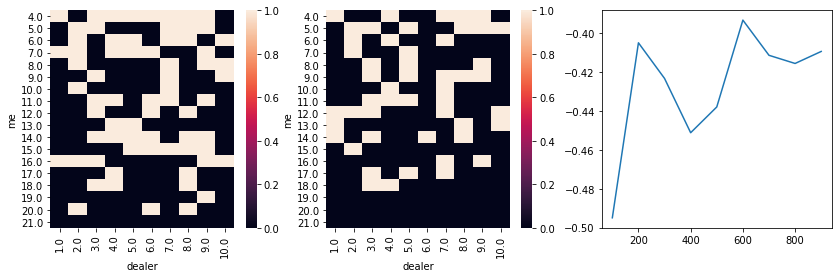

In [7]:
simulate_mc(1000, .1)

## Q-Learning, TD(0)

- Updates value function after each step, looking 1 step in future
- Updates policy after each step
- Explores 10% of the time

In [25]:
def simulate_q_learning(games, eps, alpha):
    # run through several games and record winnings

    winnings = 0
    winning_log = []
    q = initialize_q()
    p = initialize_policy()

    for ep in range(games):
        observation = env.reset()
        obs_log = []
        action_log = []
        obs_log.append(observation)
        done = 0
        for i in range(20):
            if done:
                winnings += reward
                break
            action = choose_action(observation, p, eps)
            action_log.append(action)
            observation, reward, done, info = env.step(action)  
            obs_log.append(observation)
            q = q_update_values(obs_log[i], action_log[i], reward, q, p, alpha)
            p = q_update_policy(obs_log[i], q, p)

        if ep>0 and ep%100 == 0:
            winning_log.append(winnings/ep)

    print ('Average winnings of', winnings/games)            
    visualize_policy_and_winnings(p, winning_log)

Average winnings of -0.3913


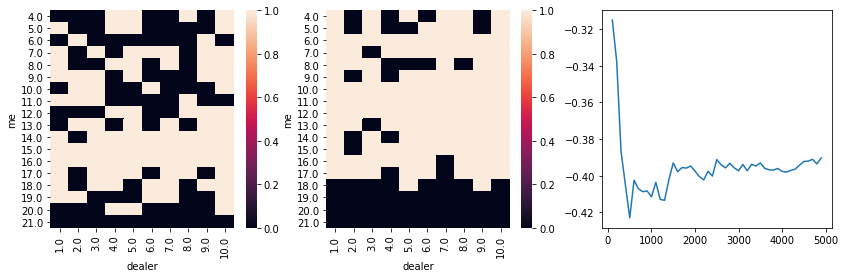

In [29]:
simulate_q_learning(5000, .05, .2)

## Test supposed optimal policy

In [10]:
def define_optimal_policy(p):
    new_p = p.copy()
    new_p['action'] = 0
    
    new_p.loc[(p['ace']==0) & (new_p['me']<=11), 'action'] = 1
    new_p.loc[(p['ace']==0) & (new_p['me']>=12) & (new_p['me']<=16) & (new_p['dealer']>=7), 'action'] = 1
    
    new_p.loc[(p['ace']==1) & (new_p['me']<=17), 'action'] = 1
    new_p.loc[(p['ace']==1) & (new_p['me']==18) & (new_p['dealer']>=9), 'action'] = 1
    
    return new_p

In [11]:
def simulate_optimal(games):
    # run through several games and record winnings

    winnings = 0
    winning_log = []
    p = initialize_policy()
    p = define_optimal_policy(p)

    for ep in range(games):
        observation = env.reset()
        obs_log = []
        action_log = []
        obs_log.append(observation)
        done = 0
        for i in range(20):
            if done:
                winnings += reward
                break
            action = choose_action(observation, p)
            action_log.append(action)
            observation, reward, done, info = env.step(action)  
            obs_log.append(observation)

        if ep>0 and ep%100 == 0:
            winning_log.append(winnings/ep)

    print ('Average winnings of', winnings/games)  
    visualize_policy_and_winnings(p, winning_log)

Average winnings of -0.052


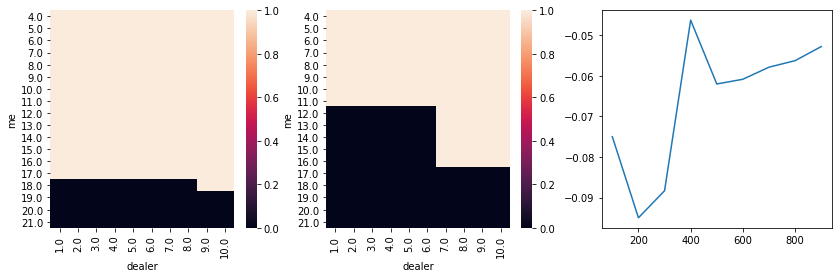

In [12]:
simulate_optimal(1000)

## Function Approximation
instead of using states, see if i can use a simple function to represent the actions.  though not sure if i need some special software or math to calculate gradient